In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
import warnings
import math
warnings.filterwarnings(action='ignore', category=FutureWarning)

import custom_dataset as ds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class model_wrapper:
    def __init__(self, model):
        self.model = model
    
    def train_model(self, dataset, epoch, batch_size=16, lr=0.001, decay=0.99):
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.model.train()
        for epoch in range(epoch):        
            epoch_loss = 0
            for X, X_t, y, y_t in tqdm(dataloader):
                optimizer.zero_grad()
                X = X.to(self.model.device)
                X_t = X_t.to(self.model.device)

                y_pred = self.model((X, X_t))
                loss = criterion(y_pred.cpu().squeeze(), y.squeeze())
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()      

            scheduler.step()
            print(f'Epoch {epoch+1}, MSE Loss: {epoch_loss/len(dataloader)}')
            
    def inference_model(self, dataset, batch_size=16):
        with torch.no_grad():
            self.model.eval()
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

            ret = []
            for X, X_t in tqdm(dataloader):
                X = X.to(self.model.device)                  
                X_t = X_t.to(self.model.device)

                '''for i in range(dataset.next_step-1):
                    y_pred = model((X, X_t))
                    X = torch.cat([X[:, 1:], y_pred[:, :1]], dim=1)
                    X_t = torch.remainder(torch.add(X_t, 1), TIME_LEN)'''
                y_pred = self.model((X, X_t))

                '''for i in range(dataset.next_step-1):
                    y_pred = model(y_pred.unsqueeze(1).unsqueeze(1))'''
                ret.append(y_pred.cpu().squeeze(1).squeeze(1))
                #ret.append(y_pred.cpu().squeeze())
        return ret

In [3]:
class SpatialMask(nn.Module):
    def __init__(self, device, mask):
        super(SpatialMask, self).__init__()
        self.device = device
        self.mask = mask
        self.linear = nn.Linear(mask.shape[0], mask.shape[0], device=device, bias=True)
        
    def forward(self, x):
        with torch.no_grad():
            self.linear.weight.data = self.linear.weight.data * self.mask
        return self.linear(x)
        
class SpatialBlock(nn.Module):
    def __init__(self, device, input_channel, output_channel, mask):
        super(SpatialBlock, self).__init__()
        self.device = device
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.spatialmask = SpatialMask(device, mask)
        self.conv1 = nn.Conv2d(input_channel, input_channel, 1, padding=0, device=device)
        self.conv_out = nn.Conv2d(input_channel*2, output_channel, 1, padding=0, device=device)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.relu(x1)
        x2 = self.spatialmask(x)
        x2 = self.relu(x2)
        out = self.conv_out(torch.cat([x1, x2], dim=1))
        out = self.relu(out)
        return out

class JuniorsDream(nn.Module):
    def __init__(self, device, mask, prev_len, hidden_channels, depth):
        super(JuniorsDream, self).__init__()        
        self.device = device      
        self.mask = mask
        self.prev_len = prev_len
        self.hidden_channels = hidden_channels
        self.depth = depth 
        
        self.first_block = SpatialBlock(device, prev_len*2, hidden_channels, mask)        
        self.spatialblock_list = nn.ModuleList([SpatialBlock(device, prev_len+hidden_channels, hidden_channels, mask) for i in range(depth-1)])
        self.last_conv = nn.Conv2d(hidden_channels, 1, 1, padding=0, device=device)   

        self.time_embedd = nn.Embedding(TIME_LEN, len(self.mask), device=device)

    def forward(self, x):
        x, xt = x        
        xt = self.time_embedd(xt)
        
        x_cur = torch.cat([x, xt], dim=1)
        x_prev = x               
        out_cur = self.first_block(x_cur)
        
        for layer in self.spatialblock_list:
            x_cur = torch.cat([xt, out_cur], dim=1)
            out_cur = layer(x_cur)
        
        out = self.last_conv(out_cur)
        out = nn.ReLU()(out)
        
        
        return out

In [4]:
file_list = []
#file_list.append(('metr-la_train.csv', 'metr-la_train_t.csv', 'metr-la_test.csv', 'metr-la_test_t.csv', 'W_metrla.csv', datetime.datetime(2012, 6, 1)))
file_list.append(('pems-bay_train.csv', 'pems-bay_train_t.csv', 'pems-bay_test.csv', 'pems-bay_test_t.csv', 'W_pemsbay.csv', datetime.datetime(2017, 6, 1)))
file_list.append(('2023_6to9.csv', '2023_6to9_t.csv', '202310.csv', '202310_t.csv', 'W_daegu.csv', datetime.datetime(2023, 10, 1)))

# 환경에 맞게 PATH 수정 / cur_data_idx로 데이터셋 변경(0~2)

In [5]:
PATH = './data/processed_data/traffic/'

cur_data_idx = 0
cur_data = [PATH + i for i in file_list[cur_data_idx][:5]] + [file_list[cur_data_idx][5]]

In [6]:
TIME_LEN = 7*24*12

prev_len = 5
hidden_channels = 80
depth = 5

mask = torch.Tensor(pd.read_csv(cur_data[4]).map(lambda x: 1 if x != 0 else 0).values).to(device)

md = JuniorsDream(device, mask, prev_len, hidden_channels, depth)
print(md)

md_wrapper = model_wrapper(md)

JuniorsDream(
  (first_block): SpatialBlock(
    (spatialmask): SpatialMask(
      (linear): Linear(in_features=325, out_features=325, bias=True)
    )
    (conv1): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
    (conv_out): Conv2d(20, 80, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
  )
  (spatialblock_list): ModuleList(
    (0-3): 4 x SpatialBlock(
      (spatialmask): SpatialMask(
        (linear): Linear(in_features=325, out_features=325, bias=True)
      )
      (conv1): Conv2d(85, 85, kernel_size=(1, 1), stride=(1, 1))
      (conv_out): Conv2d(170, 80, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU()
    )
  )
  (last_conv): Conv2d(80, 1, kernel_size=(1, 1), stride=(1, 1))
  (time_embedd): Embedding(2016, 325)
)


In [7]:
next_step = 12

train_data = ds.Link_Time_Dataset(cur_data[0], cur_data[1], prev_len, next_step)
scaler = train_data.scaler
md_wrapper.train_model(train_data, 25, batch_size=64)

100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:13<00:00, 51.79it/s]


Epoch 1, MSE Loss: 0.02095250945284908


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 79.52it/s]


Epoch 2, MSE Loss: 0.003755383808097309


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 78.81it/s]


Epoch 3, MSE Loss: 0.003374576469308094


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 76.63it/s]


Epoch 4, MSE Loss: 0.0032050799836938764


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 73.95it/s]


Epoch 5, MSE Loss: 0.0030877733830814522


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 74.65it/s]


Epoch 6, MSE Loss: 0.0029803889486870235


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 73.61it/s]


Epoch 7, MSE Loss: 0.0029161935340037896


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:10<00:00, 67.50it/s]


Epoch 8, MSE Loss: 0.0028241234388106558


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:10<00:00, 67.33it/s]


Epoch 9, MSE Loss: 0.0027525255297351737


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:10<00:00, 67.36it/s]


Epoch 10, MSE Loss: 0.0026938416741733606


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:10<00:00, 66.89it/s]


Epoch 11, MSE Loss: 0.002624079623081557


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 68.11it/s]


Epoch 12, MSE Loss: 0.0025634786930715885


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 68.73it/s]


Epoch 13, MSE Loss: 0.002508390469216358


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 68.35it/s]


Epoch 14, MSE Loss: 0.002449529535678106


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:10<00:00, 67.60it/s]


Epoch 15, MSE Loss: 0.002387822042253581


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 68.08it/s]


Epoch 16, MSE Loss: 0.0023454956773682222


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 69.25it/s]


Epoch 17, MSE Loss: 0.002299187264768133


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 68.14it/s]


Epoch 18, MSE Loss: 0.0022452397321638486


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:10<00:00, 67.99it/s]


Epoch 19, MSE Loss: 0.002214612685972551


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:10<00:00, 66.93it/s]


Epoch 20, MSE Loss: 0.00215770197854213


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 68.48it/s]


Epoch 21, MSE Loss: 0.0021244389207020183


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 68.63it/s]


Epoch 22, MSE Loss: 0.002085144756026292


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 72.60it/s]


Epoch 23, MSE Loss: 0.00204568403731922


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 73.91it/s]


Epoch 24, MSE Loss: 0.0019987163878634902


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 73.79it/s]

Epoch 25, MSE Loss: 0.0019724425048266046


In [8]:
inf_data = ds.Link_Time_Dataset(cur_data[2], cur_data[3], prev_len, next_step, get_true=False, scaler=scaler)
ret = md_wrapper.inference_model(inf_data, batch_size=64)

100%|███████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 149.04it/s]


In [9]:
ret

[tensor([[0.8730, 0.8716, 0.8517,  ..., 0.9247, 0.8726, 0.8894],
         [0.8682, 0.8757, 0.8534,  ..., 0.9287, 0.8726, 0.8923],
         [0.8708, 0.8748, 0.8400,  ..., 0.9302, 0.8711, 0.8905],
         ...,
         [0.7508, 0.8853, 0.7970,  ..., 0.8934, 0.8451, 0.8459],
         [0.7666, 0.8837, 0.7888,  ..., 0.8788, 0.8399, 0.8348],
         [0.7329, 0.8860, 0.7870,  ..., 0.8674, 0.8302, 0.8318]]),
 tensor([[0.7562, 0.8872, 0.7694,  ..., 0.8600, 0.8212, 0.8283],
         [0.8124, 0.8832, 0.7642,  ..., 0.8616, 0.8242, 0.8164],
         [0.7318, 0.8817, 0.7698,  ..., 0.8658, 0.8292, 0.7975],
         ...,
         [0.7811, 0.8889, 0.6886,  ..., 0.8803, 0.8378, 0.8755],
         [0.7856, 0.8931, 0.6837,  ..., 0.8770, 0.8337, 0.8722],
         [0.7927, 0.8874, 0.6866,  ..., 0.8706, 0.8350, 0.8688]]),
 tensor([[0.7945, 0.8931, 0.6821,  ..., 0.8763, 0.8337, 0.8738],
         [0.8006, 0.8880, 0.6994,  ..., 0.8668, 0.8369, 0.8679],
         [0.8128, 0.8726, 0.7158,  ..., 0.8693, 0.8393, 0.

In [10]:
result = pd.DataFrame(torch.cat(ret).numpy())

In [13]:
def show_plot(d1, d2):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(d1, 'r', label='Ground Truth')
    ax.plot(d2, 'b', label='Prediction')
    ax.grid(True)
    ax.set_xlabel('Time', loc='right')
    ax.set_ylabel('Speed', loc='top')
    ax.legend()
    
    plt.show()

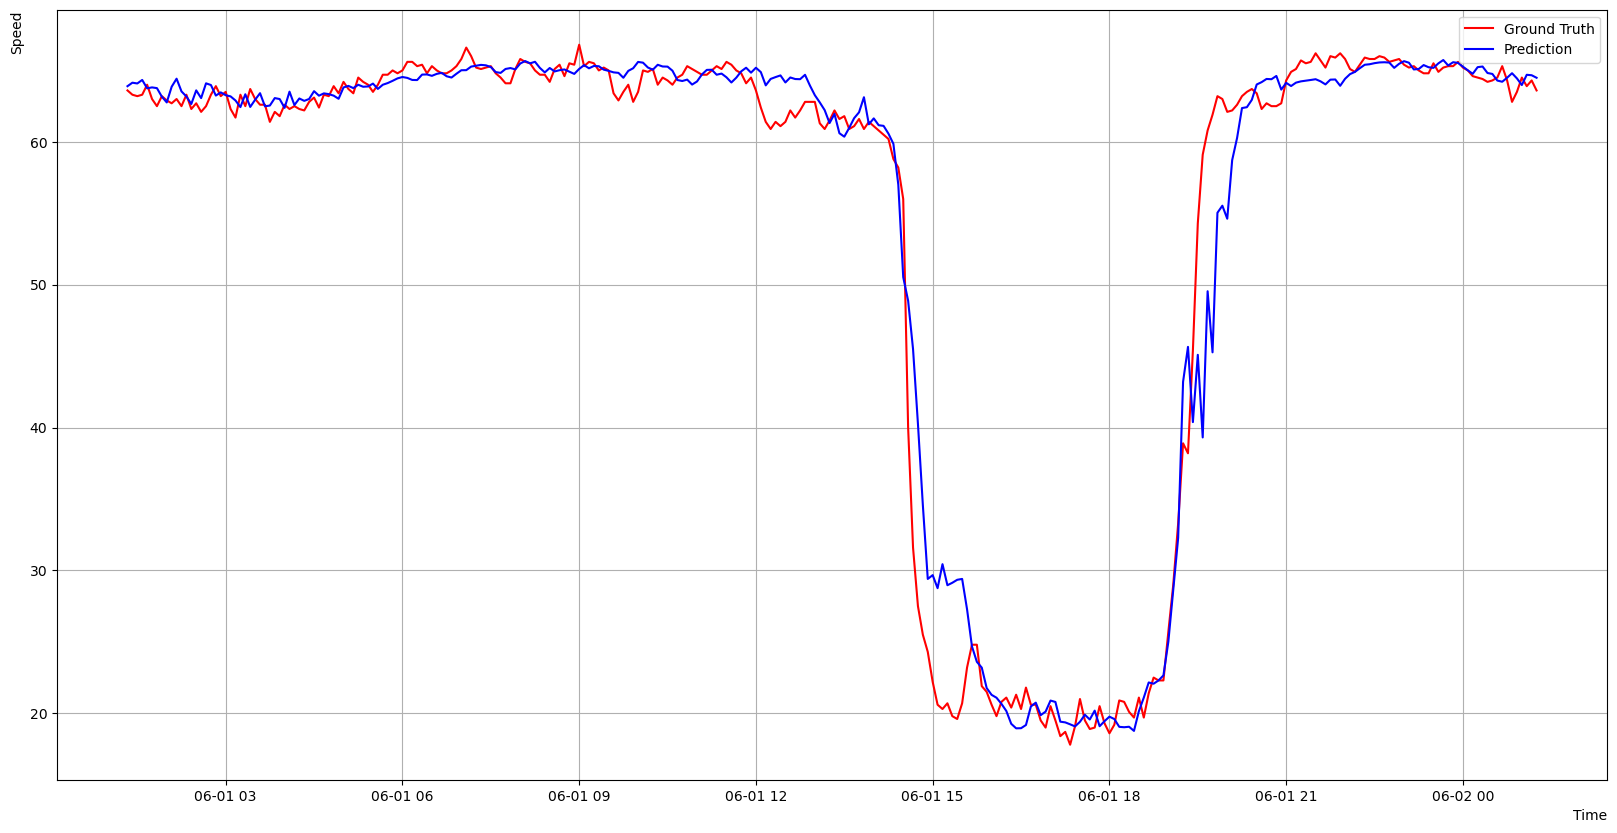

1.4990298562579685


In [25]:
d1_start = prev_len + next_step - 1
start_offset = 288*0

time_len = 288 * 1
road_idx = 1

d = pd.read_csv(cur_data[2])
x = [cur_data[5] + i*datetime.timedelta(minutes=5) for i in range(d1_start+start_offset, d1_start+start_offset+time_len)]
d1 = d.iloc[d1_start+start_offset:d1_start+start_offset+time_len, road_idx]
d1 = pd.Series(d1).set_axis(x)
d2 = scaler.inverse_transform(result)[start_offset:time_len+start_offset, road_idx]
d2 = pd.Series(d2).set_axis(x)
show_plot(d1, d2)
print(np.abs((d1-d2)).mean())

In [15]:
mx = 0
mae = []
mse = []
mape = []
for i in range(len(d.iloc[0])):
    d1 = d.iloc[d1_start:, i].reset_index(drop=True)
    d2 = scaler.inverse_transform(result)[:,i]
    err = np.abs(d1-d2)
    print(i, err.mean(), np.sqrt((err**2).mean()))
    mx = max(mx, err.max())
    mae += err.to_list()
    mse += (err**2).to_list()
    mape += (err / d1).tolist()

mae_v = np.array(mae).mean()
rmse_v = np.sqrt(np.array(mse).mean())
mape_v = np.array(mape)
np.place(mape_v, np.isinf(mape_v), [0])
mape_v = mape_v.sum() / np.count_nonzero(mape_v)
print(f'MAX diff: {mx}, MAE: {mae_v}, RMSE: {rmse_v}, MAPE: {mape_v*100}%')

0 2.061083915724604 4.162356423484319
1 1.8148977087247349 4.475604960669414
2 3.6917749473469152 7.6991179353548045
3 2.4253570995436973 4.481874422981463
4 3.0462460425877618 5.548395237740766
5 2.178609404249846 5.6143512345085025
6 3.5938598859288033 7.178574855666684
7 1.9585977959279004 4.189607192012764
8 2.8168595513076635 5.802200960153076
9 1.961877346613854 4.40001263415011
10 5.672463020599397 11.105391572373199
11 2.6448762035546807 6.182508853633647
12 1.3107761812121617 2.8892468020247506
13 2.802735898932632 4.605105403796116
14 1.3995136430842976 2.8718021446205753
15 1.775948157956295 3.928219767257845
16 1.0083127707408843 2.057904035204874
17 2.1195920744941934 3.8649072110058618
18 0.6687691777004602 1.0911226213069236
19 3.6340470157881617 6.868262518371437
20 2.6149898161914664 5.525745242227711
21 2.510321007323398 4.804230925720941
22 1.3131668324815542 2.3137518946893856
23 2.9401239372582517 5.083994061848779
24 0.9772880716093839 1.456483471645425
25 1.81290

205 2.04464121607991 3.8202474405022215
206 1.733456698065565 2.7168009063207488
207 2.520652269476641 3.837543526295071
208 2.0110149641426243 3.9427922589826427
209 1.0303024523775741 1.9943622745648903
210 2.0693050062059255 3.989364362910197
211 2.410874941132285 4.3944393348882
212 1.1285520695136075 1.656795874011748
213 2.698529709071087 5.578608526765885
214 1.8458218260466057 3.215526405784427
215 1.6727633359480878 2.8214420405448224
216 1.6128795360147623 3.935492722320508
217 2.6079255310856566 4.378439332415596
218 1.476782275484754 2.938170568567257
219 1.911061164001366 4.029274435685898
220 1.525240780869309 3.240628362710884
221 1.639972014993374 3.3544614834869364
222 1.3638244898730618 2.8810673601286467
223 1.305417707368925 2.43839759331428
224 1.6495122061147318 3.4976941093047365
225 2.1864453498861565 4.385312872134223
226 2.594328539689972 6.025738734265199
227 2.5453800907382718 5.742206384497877
228 1.250897658158764 2.3903763351159
229 1.9022537925026632 3.1